In [1]:
self_energy_intial_value = 0
chemical_potential = 0

In [2]:
def rho(epsilon):
    return (1/(2*np.pi)) * np.sqrt(4 - epsilon**2)


In [3]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy import integrate

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import irbasis3

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
})

In [5]:
from scipy.integrate import quad
assert np.abs(quad(rho, -2, 2)[0] - 1) < 1e-9 # Check rule

In [29]:
D = 2
temp = 0.1/D
beta = 1/temp
wmax = 10.0 * D
lambda_ = beta * wmax
eps = 1e-9

wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=lambda_)
basis = irbasis3.FiniteTempBasis(K, statistics="F", beta=beta, eps=eps)
L = basis.size

# Sparse sampling in tau
smpl_tau = irbasis3.TauSampling(basis)
ntau = smpl_tau.sampling_points.size
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = irbasis3.MatsubaraSampling(basis)
nw = smpl_matsu.sampling_points.size
print("cond (matsu): ", smpl_matsu.cond)

cond (tau):  11.408396757532548
cond (matsu):  17.755472692037568


In [30]:
print(smpl_matsu.sampling_points)

[-879 -837 -795 -339 -201 -137 -101  -75  -59  -45  -35  -29  -23  -19
  -15  -13  -11   -9   -7   -5   -3   -1    1    3    5    7    9   11
   13   15   19   23   29   35   45   59   75  101  137  201  339  795
  837  879]


In [31]:
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

class IPTSolver:
    def __init__(self, U, basis, rho_omega, omega_range, deg_leggauss=1000):
        assert isinstance(omega_range, tuple)
        assert omega_range[0] < omega_range[1]
        self.U = U
        self.basis = basis
        self.beta = basis.beta
        self.rho_omega = rho_omega

        x_, w_ = leggauss(deg_leggauss)
        self._quad_rule = scale_quad(x_, w_, omega_range[0], omega_range[1])

        self._smpl_matsu = irbasis3.MatsubaraSampling(basis)
        self._smpl_tau = irbasis3.TauSampling(basis)

    def gloc_iv(self, sigma_iv):
        """
        Compute G_loc(iv) from Sigma_iv

        G_loc(iv) \simeq \sum_q w_q rho(x_q)/(iv - w_q - \Sigma(iv))
        """
        quad_points = self._quad_rule[0]
        quad_weight = self._quad_rule[1]
        #print(quad_points, quad_weight)
        #松原周波数
        iv = 1j * self._smpl_matsu.sampling_points * np.pi/self.beta
        r = np.einsum('q,q,wq->w',
            quad_weight,
            self.rho_omega(quad_points),
            1/((iv-sigma_iv)[:,None] - quad_points[None,:]),
            optimize=True
        )
        return r
    
    def g0_iv(self, gloc, sigma_iw):
        """
        Compute \mathcal{G}(iv) from G_loc(iv) and Sigma(iv)
        """
        return 1/(1/gloc + sigma_iw)

    def sigma_iv(self, g0_iv):
        """
        Compute Sigma(tau) from \mathcal{G}(iv)
        """
        g0_IR = self._smpl_matsu.fit(g0_iv, axis=0)
        g0_tau = self._smpl_tau.evaluate(g0_IR)
        sigma_tau = (self.U**2) * (g0_tau**2) * g0_tau[::-1]
        sigma_IR = self._smpl_tau.fit(sigma_tau)
        return self._smpl_matsu.evaluate(sigma_IR, axis=0)
    
    def new_sigma_iv(self, sigma_iv):
        gloc_iv = self.gloc_iv(sigma_iv)
        g0_iv = self.g0_iv(gloc_iv, sigma_iv)
        r = self.sigma_iv(g0_iv)
        return r

In [40]:
niter = 100000
mixing = 0.1

#U_1 = np.linspace(12/D,13/D,5)
#U_1 = 2*np.array([1e-3/D, 1/D, 2/D, 3/D, 4/D, 5/D, 6/D, 6.5/D])
U_1 = 2*np.linspace(5/D, 6.5/D, 20)

def normalize_factor(u, sigma_ini=None) :
    # Initialize solver
    solver = IPTSolver(u, basis, rho, (-2,2))

    if sigma_ini is None:
        sigma_ini = np.zeros_like(solver._smpl_matsu.sampling_points.size, dtype=np.complex128)

    sigma_iv = sigma_ini.copy()

    for iter in range(niter):
        new_sigma_iv = solver.new_sigma_iv(sigma_iv)
        rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()
        print(iter, rdiff)
        if rdiff < 1e-5:
            break
        sigma_iv = mixing * new_sigma_iv + (1-mixing) * sigma_iv

    center = int(len(sigma_iv.imag)/2)
    z = 1/(1-(sigma_iv.imag[center] - sigma_iv.imag[center-1])/(solver._smpl_matsu.sampling_points[center] - solver._smpl_matsu.sampling_points[center-1]))

    return z, sigma_iv

Z = []
Sigma_U = []
for u in U_1:
    print("U=",u)
    zz, s_u = normalize_factor(u, Sigma_U[-1] if len(Sigma_U) > 0 else None)
    Sigma_U.append(s_u)
    #print(Sigma_U)
    if abs(zz) > 1e-10:
        Z.append(zz)

    else:
        break



U= 5.0
0 inf
1 9.280143414276107
2 4.4769725718573445
3 2.8841834105292135
4 2.089047604261445
5 1.6098568177819361
6 1.29134752308497
7 1.0707973914320703
8 0.9060670712813724
9 0.7784822199458976
10 0.6769141780063929
11 0.5942798965912204
12 0.5258560143477098
13 0.4701185727940957
14 0.42370795145728446
15 0.3836835822577656
16 0.34863217721977546
17 0.3175389423567526


/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_15634/3262742419.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()


18 0.2901325587707895
19 0.26583223236906445
20 0.24417282981242858
21 0.2247773526789265
22 0.20733692407417428
23 0.19159599978566
24 0.1773412790368604
25 0.1650878178643843
26 0.15416464252524498
27 0.14413470725165503
28 0.13490328186683573
29 0.12638853165488337
30 0.11851937121391966
31 0.11123373492173277
32 0.10447717262760921
33 0.09820170137712692
34 0.09236486028893924
35 0.0869289278152138
36 0.08186026969832795
37 0.07712879280493165
38 0.0727074852581532
39 0.06857202731693784
40 0.06470046057179003
41 0.06107290546016837
42 0.05767131901607479
43 0.05447928627861724
44 0.05148183998491678
45 0.04864816606424046
46 0.04596850067243489
47 0.043450507338686196
48 0.04108306825328548
49 0.03885596872553723
50 0.036759809159136715
51 0.03478592721769721
52 0.03292632881433826
53 0.03117362676587745
54 0.02952098612424509
55 0.027962075341428427
56 0.02649102254500172
57 0.025102376302692492
58 0.02379107034022755
59 0.022552391749197747
60 0.02138195228345247
61 0.0202756623

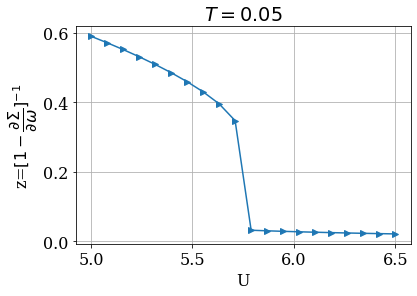

In [41]:
plt.plot(U_1,Z, marker=">")
#plt.xticks(np.arange(0,7,1))
plt.xlabel("U")
plt.ylabel("z=$[1-\dfrac{\partial \Sigma}{\partial \omega}]^{-1}$")
#plt.ylim(0,1.1)
plt.title("$T={0}$".format(1/beta))
plt.grid()

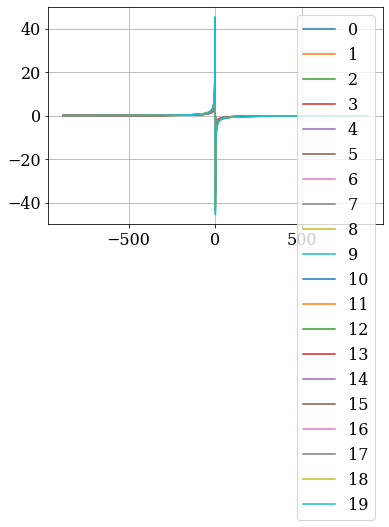

In [42]:
for i in range(len(Sigma_U)):
    plt.plot(smpl_matsu.sampling_points, Sigma_U[i].imag, label=str(i))
plt.grid()
plt.legend()

In [35]:
#plt.plot(solver._quad_rule[0],solver._quad_rule[1])

In [36]:
# lll = leggauss(10000)
# plt.plot(lll[0],lll[1])

In [37]:

# sigma_iv = np.zeros_like(
#     solver._smpl_matsu.sampling_points.size, dtype=np.complex128)

In [62]:
# # Gloc_iv
# gloc_iv = solver.gloc_iv(sigma_iv)
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     gloc_iv.real,label = "Re $G_{local}(i\omega_n)$"
# )
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     gloc_iv.imag, label = "Im $G_{local}(i\omega_n)$"
# )

# plt.xlabel("$\omega_n$")
# plt.legend()

In [61]:
# # Gloc_iv
# g0_iv = solver.g0_iv(gloc_iv, sigma_iv)
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     g0_iv.real ,label = "Re $G_{0}(i\omega_n)$"
# )
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     g0_iv.imag,  label = "Im $G_{0}(i\omega_n)$"
# )
# plt.xlabel("$\omega_n$")
# plt.legend()


In [63]:
# for iter in range(niter):
#     new_sigma_iv = solver.new_sigma_iv(sigma_iv)
#     rdiff = np.abs(new_sigma_iv - sigma_iv).max()/np.abs(sigma_iv).max()
#     print(iter, rdiff)
#     if rdiff < 1e-10:
#         break
#     sigma_iv = mixing * new_sigma_iv + (1-mixing) * sigma_iv


In [64]:
# fig = plt.figure(figsize=(12,5))
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     sigma_iv.imag,
#     marker="x"
# )
# plt.xticks(np.arange(min(solver._smpl_matsu.sampling_points),max(solver._smpl_matsu.sampling_points),20))
# plt.grid()

In [65]:
# center = int(len(sigma_iv.imag)/2)
# print(center)
# (sigma_iv.imag[center] - sigma_iv.imag[center-1])/(solver._smpl_matsu.sampling_points[center] - solver._smpl_matsu.sampling_points[center-1])


In [66]:
# plt.plot(
#     solver._smpl_matsu.sampling_points,
#     sigma_iv.real,
#     marker="x"
# )
# plt.ylim(-0.1,0.1)

In [19]:
#max(solver._smpl_matsu.sampling_points)

In [96]:
# plt.rcParams.update({
#     #"text.usetex": True,
#     "font.family": "serif",
#     "font.size": 16
# })

In [95]:
# from scipy.special import eval_legendre

# nx = 1000
# nvec = np.arange(5)
# xvec = np.linspace(-1, 1, nx)
# legval = eval_legendre(nvec[None,:], xvec[:,None])
# print(legval.shape)

In [94]:
# for n in nvec:
#     plt.plot(xvec, legval[:,n], label=r'$n='+str(n)+r'$')
# plt.grid()
# plt.legend(loc='best', frameon=False)
# plt.xlabel(r'$x$')
# plt.ylabel(r'$P_n(x)$')
# plt.tight_layout()
# plt.savefig('legendre_polynomials.pdf', transparent=True)
# ;
# ''